# Challenge 3 Avanzado  

# Enfermedades Cardiovasculares  ❤️

#### PÉREZ ROSAS LUIS ALFREDO | MCD | GRUPO 2 | UDG


Este challenge avanzado permitirá a los estudiantes aplicar PySpark para analizar grandes volúmenes de datos relacionados con un tema cercano a su investigación de tesis, integrando los conocimientos adquiridos en los challenges anteriores.

Utilizar APIs avanzadas como Spark Streaming o Spark ML para trabajar con una gran base de datos en tiempo real o construir un modelo predictivo complejo. 

## 1) Parámetros de ejecución

Ajusta la ruta al CSV (usa `,` como separador por defecto). Si tu archivo tiene otra columna objetivo distinta a `target` o `num`, ajusta `LABEL_BASE_COL`.


In [2]:
# Parámetros
DATA_PATH = "data/heart_disease_uci.csv"  # <-- CAMBIA ESTA RUTA
CSV_SEP = ","                                 # separador común del CSV
OUTDIR = "outputs_heart"                       # carpeta de salida

# Si conoces la columna objetivo exacta, indícala aquí (por defecto intentará detectar entre 'target' o 'num')
LABEL_BASE_COL = None                          # e.g., "target" o "num"; si None se detecta automáticamente

# %matplotlib inline  # Descomenta si estás en Jupyter clásico


## 2) Inicializar Spark

In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("challenge-3-avanzado-heart-v2")
    .getOrCreate()
)
spark

## 3) Carga de datos

In [4]:
from pyspark.sql import functions as F
import os

os.makedirs(OUTDIR, exist_ok=True)

raw = spark.read.csv(DATA_PATH, header=True, inferSchema=True, sep=CSV_SEP)
raw.printSchema()
raw.show(5)

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: boolean (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalch: integer (nullable = true)
 |-- exang: boolean (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: string (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: string (nullable = true)
 |-- num: integer (nullable = true)

+---+---+------+---------+---------------+--------+----+-----+--------------+------+-----+-------+-----------+---+-----------------+---+
| id|age|   sex|  dataset|             cp|trestbps|chol|  fbs|       restecg|thalch|exang|oldpeak|      slope| ca|             thal|num|
+---+---+------+---------+---------------+--------+----+-----+--------------+------+-----+-------+-----------+---+--------------

### Diccionario de Datos

id	:: Identificador del paciente. <br>
age	:: 	Edad.<br>
gender	:: 	Género.<br>
height	:: 	Estatura.<br>
weight	:: 	Peso.<br>
ap_hi	:: 	Presión arterial sistólica  <br>
ap_lo	:: 	Presión arterial diastólica <br>
cholesterol	:: 	Nivel de colesterol<br>
gluc	:: 	Nivel de glucosa: <br>
smoke	:: 	¿Es fumador?<br>
alco	:: 	¿Bebe alcohol?<br>
active	:: 	¿Realiza actividad física?<br>
cardio	:: 	¿Tiene alguna enfermedad cardiovascular diagnosticada?

## 4) Detección de la columna objetivo y creación de `label` binaria

In [5]:
# Detectar columna objetivo si no se especificó
candidates = [c for c in raw.columns if c.lower() in ("target", "num")]
base_col = LABEL_BASE_COL if LABEL_BASE_COL else (candidates[0] if candidates else None)

if base_col is None:
    raise ValueError("No se pudo detectar la columna objetivo automáticamente. "
                     "Indica LABEL_BASE_COL con el nombre correcto (p. ej., 'target' o 'num').")

print("Columna base para etiqueta:", base_col)

# Mapeo a binaria: label = 1 si valor > 0, 0 en otro caso
df = raw.withColumn("label", (F.col(base_col).cast("double") > F.lit(0.0)).cast("int"))
df.select(base_col, "label").groupBy("label").count().orderBy("label").show()

Columna base para etiqueta: num
+-----+-----+
|label|count|
+-----+-----+
|    0|  411|
|    1|  509|
+-----+-----+



## 5) EDA con gráficas

**Importante**: Usamos `matplotlib` (una figura por gráfico, sin estilos ni colores específicos).  
Se convertirán los datos a pandas con `toPandas()` para graficar. Si el dataset es muy grande, considera muestrear (`sample()`).


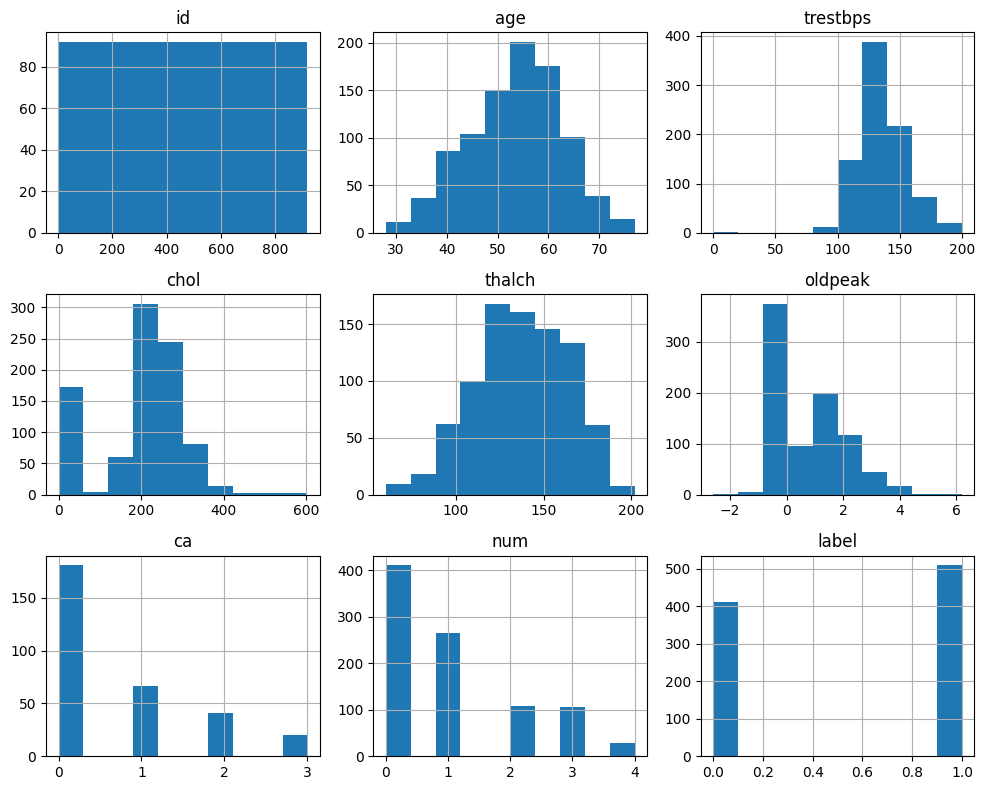

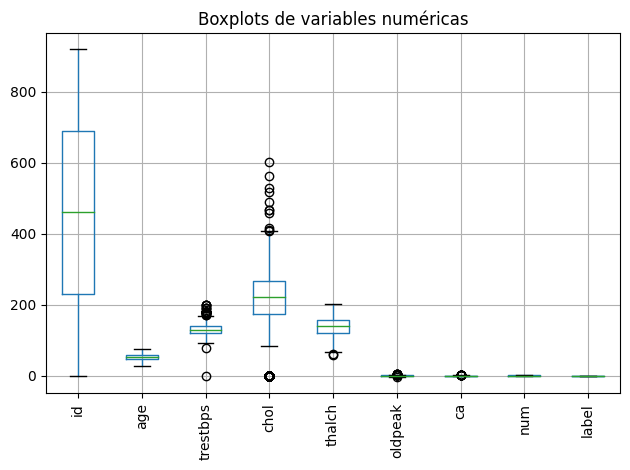

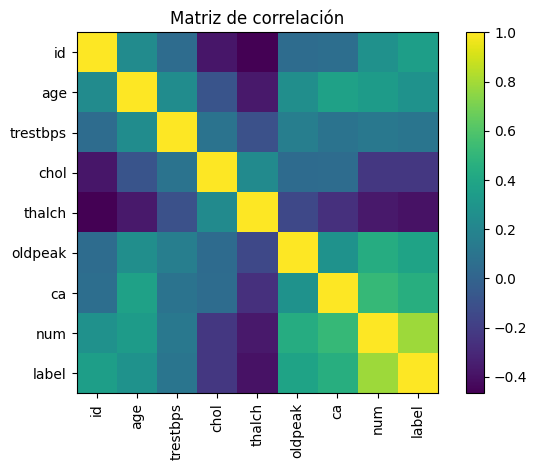

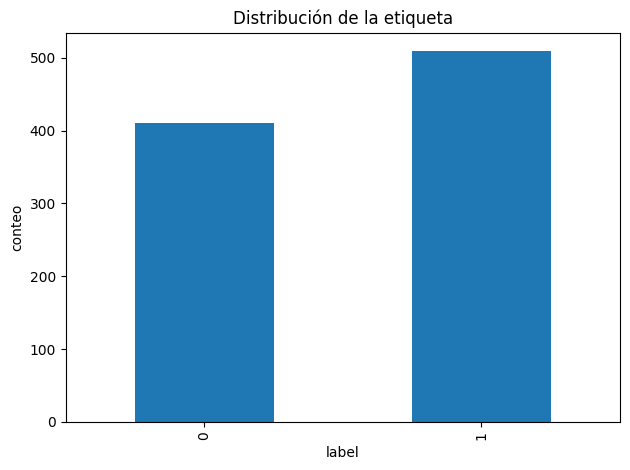

In [6]:
import matplotlib.pyplot as plt

# Seleccionar solo columnas numéricas para las gráficas
numeric_cols = [c for (c, t) in df.dtypes if t in ("int", "bigint", "double", "float")]
pdf = df.select(numeric_cols).toPandas()

# 5.1 Histogramas
ax = pdf.hist(figsize=(10, 8))
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "histogramas.png"))
plt.show()

# 5.2 Boxplots
plt.figure()
pdf.boxplot(rot=90)
plt.title("Boxplots de variables numéricas")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "boxplots.png"))
plt.show()

# 5.3 Matriz de correlación
plt.figure()
corr = pdf.corr(numeric_only=True)
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Matriz de correlación")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "correlacion.png"))
plt.show()

# 5.4 Distribución de la etiqueta
if "label" in df.columns:
    label_pdf = df.select("label").toPandas()
    plt.figure()
    label_pdf["label"].value_counts().sort_index().plot(kind="bar")
    plt.title("Distribución de la etiqueta")
    plt.xlabel("label")
    plt.ylabel("conteo")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "distribucion_label.png"))
    plt.show()

## 6) Preparación de datos y *features*

In [7]:
# Revisa tu esquema
df.printSchema()

# Columnas del ensamblador (ajusta si usaste otro nombre)
# Evita meter 'label' ni la columna objetivo original (target/num)
exclude = {"label", "target", "num", "features", "features_raw"}
feature_cols = [c for c, t in df.dtypes if c not in exclude]

# Qué columnas no son numéricas aún
non_numeric = [c for c, t in df.dtypes if c in feature_cols and t not in ("int","bigint","double","float")]
missing = [c for c in feature_cols if c not in dict(df.dtypes)]
print("No numéricas:", non_numeric)
print("Inexistentes:", missing)


root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: boolean (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalch: integer (nullable = true)
 |-- exang: boolean (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: string (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: string (nullable = true)
 |-- num: integer (nullable = true)
 |-- label: integer (nullable = true)

No numéricas: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Inexistentes: []


In [24]:
from pyspark.sql.functions import col, regexp_replace, trim
from pyspark.sql import functions as F

df_cast = df

# Elimina filas con nulos en cualquier columna
df_cast.na.drop()


for c in non_numeric:
    # Limpia espacios y comas decimales si las hubiera
    df_cast = df_cast.withColumn(c, trim(col(c)))
    df_cast = df_cast.withColumn(c, regexp_replace(col(c), ",", "."))  # por si hay comas decimales
    df_cast = df_cast.withColumn(c, col(c).cast("double"))

# Recalcula solo columnas numéricas reales para el assembler
numeric_feature_cols = [
    c for c, t in df_cast.dtypes
    if c in feature_cols and t in ("int","bigint","double","float")
]
print("Usaré estas columnas numéricas:", numeric_feature_cols)

print(df_cast)


Usaré estas columnas numéricas: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
DataFrame[id: int, age: int, sex: double, dataset: double, cp: double, trestbps: int, chol: int, fbs: double, restecg: double, thalch: int, exang: double, oldpeak: double, slope: double, ca: int, thal: double, num: int, label: int]


In [25]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [26]:
#
#assembler = VectorAssembler(
#    inputCols=numeric_feature_cols,
#    outputCol="features_raw",
#    handleInvalid="skip"   # en Spark 3.5 soportado; salta filas con nulos/inválidos
#)
#scaler = StandardScaler(inputCol="features_raw", outputCol="features")

#prep = Pipeline(stages=[assembler, scaler])

assembler = VectorAssembler(inputCols=numeric_feature_cols, outputCol="features_raw", handleInvalid="keep")
scaler = StandardScaler(inputCol="features_raw", outputCol="features")
prep = Pipeline(stages=[assembler, scaler])


prepared = prep.fit(df_cast).transform(df_cast)

train, test = prepared.randomSplit([0.8, 0.2], seed=42)
train.count(), test.count()


(771, 149)

## 7) Modelado: Logistic Regression y Random Forest

In [40]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import Imputer

# Impute missing values in numeric features before modeling
imputer = Imputer(
	inputCols=numeric_feature_cols,
	outputCols=[f"{c}_imputed" for c in numeric_feature_cols]
).setStrategy("mean")

df_cast.na.drop()	
df_cast.dropna()
df_cast.dropna(how='all')

df_imputed = imputer.fit(df_cast).transform(df_cast)

# Update assembler to use imputed columns
imputed_feature_cols = [f"{c}_imputed" for c in numeric_feature_cols]
assembler = VectorAssembler(inputCols=imputed_feature_cols, outputCol="features_raw", handleInvalid="keep")
scaler = StandardScaler(inputCol="features_raw", outputCol="features")
prep = Pipeline(stages=[assembler, scaler])

prepared = prep.fit(df_imputed).transform(df_imputed)
train, test = prepared.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol="label")
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=200)

lr_model = lr.fit(train)
rf_model = rf.fit(train)

pred_lr = lr_model.transform(test)
pred_rf = rf_model.transform(test)

pred_lr.select("label", "prediction", "probability").show(5, truncate=False)
pred_rf.select("label", "prediction", "probability").show(5, truncate=False)

Py4JJavaError: An error occurred while calling o1244.fit.
: org.apache.spark.SparkException: surrogate cannot be computed. All the values in sex,dataset,cp,fbs,restecg,exang,slope,thal are Null, Nan or missingValue(NaN)
	at org.apache.spark.ml.feature.Imputer.fit(Imputer.scala:199)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)


## 8) Evaluación (AUC)

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
auc_lr = evaluator.evaluate(pred_lr)
auc_rf = evaluator.evaluate(pred_rf)

print("AUC LR:", auc_lr)
print("AUC RF:", auc_rf)

NameError: name 'pred_lr' is not defined

## 9) Curvas ROC y PR (LR, training summary)

In [33]:
# Curvas obtenidas del summary de entrenamiento de LR
try:
    train_summary = lr_model.summary

    # ROC
    roc_df = train_summary.roc.toPandas()
    plt.figure()
    plt.plot(roc_df['FPR'], roc_df['TPR'])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curva ROC (LR, training)')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "roc_lr_training.png"))
    plt.show()

    # PR
    pr_df = train_summary.pr.toPandas()
    plt.figure()
    plt.plot(pr_df['recall'], pr_df['precision'])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall (LR, training)')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "pr_lr_training.png"))
    plt.show()
except Exception as e:
    print("[WARN] No se pudieron generar curvas LR:", e)

[WARN] No se pudieron generar curvas LR: name 'lr_model' is not defined


## 10) Matrices de confusión (Spark puro)

In [34]:
import numpy as np

def confusion_matrix_spark(pred_df):
    cm_pdf = (
        pred_df.groupBy("label", "prediction")
        .count()
        .toPandas()
    )
    labels = sorted(set(cm_pdf["label"]).union(set(cm_pdf["prediction"])))
    size = len(labels)
    mat = [[0 for _ in range(size)] for _ in range(size)]
    for _, row in cm_pdf.iterrows():
        i = labels.index(row["label"])
        j = labels.index(row["prediction"])
        mat[i][j] = int(row["count"])
    return np.array(mat), labels

cm_rf, labels_rf = confusion_matrix_spark(pred_rf)
plt.figure()
plt.imshow(cm_rf, interpolation="nearest")
plt.title("Matriz de confusión (RF)")
plt.xlabel("Predicho")
plt.ylabel("Real")
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        plt.text(j, i, int(cm_rf[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "confusion_rf.png"))
plt.show()

cm_lr, labels_lr = confusion_matrix_spark(pred_lr)
plt.figure()
plt.imshow(cm_lr, interpolation="nearest")
plt.title("Matriz de confusión (LR)")
plt.xlabel("Predicho")
plt.ylabel("Real")
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        plt.text(j, i, int(cm_lr[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "confusion_lr.png"))
plt.show()

NameError: name 'pred_rf' is not defined

## 11) Importancia de variables (RF)

In [35]:
import pandas as pd

fi = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_model.featureImportances.toArray()
}).sort_values("importance", ascending=False)

fi.head(15)

NameError: name 'rf_model' is not defined

In [15]:
# Gráfico de importancia
plt.figure()
plt.bar(fi["feature"], fi["importance"])
plt.xticks(rotation=90)
plt.title("Importancia de variables (RF) — Heart Disease")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "feature_importance_rf.png"))
plt.show()

fi.to_csv(os.path.join(OUTDIR, "feature_importance_rf.csv"), index=False)

NameError: name 'fi' is not defined

<Figure size 640x480 with 0 Axes>

## 12) Conclusiones
- Resume resultados y elige el mejor modelo para el caso.
- Discute *trade-offs* (interpretabilidad vs. desempeño).
- (Opcional) Próximos pasos: balanceo de clases, tuning adicional (CrossValidator), MLflow, explicabilidad.
